In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string

In [2]:
#load data
df = pd.read_csv('data/kjv.csv')
#rename columns
df = df.rename(columns = {'field': 'Code',
                          'field.1': 'Book',
                          'field.2': 'Chapter',
                          'field.3': 'Verse', 
                          'field.4': 'Words'})

In [3]:
#load titles data
titles = pd.read_csv('data/key_english.csv')
#rename columns
titles = titles.rename(columns = {'field': 'Book', 
                                  'field.1': 'Title',
                                  'field.2': 'OT/NT',
                                  'field.3': 'GenreCode'})

In [4]:
#load genre data
genre = pd.read_csv('data/key_genre_english.csv')
#rename columns
genre = genre.rename(columns = {'field': 'GenreCode', 
                                'field.1': 'Genre'})

In [5]:
#merge titles with genre
merge = titles.merge(genre)
merge.drop(merge.columns[[3]], axis=1, inplace=True)
#merge merge with df
data = df.merge(merge)
#rearrannge columns
data = data[['Code', 'Title', 'OT/NT', 'Genre', 'Book', 'Chapter', 'Verse', 'Words']]

# NLP

In [6]:
#import libraries for NLP
import spacy
nlp = spacy.load('en')
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LsiModel, HdpModel, CoherenceModel
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [7]:
#prepare data for NLP processing
text = data.Words.tolist()
text = ' '.join(text)
text = unicode(text)

In [8]:
#use spacy to parse text
doc = nlp(text)

In [9]:
#add stop words to spacy stopwords
my_stop_words = [u'thy', u'shall', u'thou', u'unto', u'thee', u'hast', u'hath', u'let', u'o', u'art', u'ye', 
                 u'say', u'\'s', u'saith']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [10]:
#lemmatize the text
texts = [[token.lemma_ for token in doc if token.lemma_ != '-PRON-' and not token.is_stop and not token.is_punct]]

In [11]:
#create dictionary
dictionary = Dictionary(texts)

In [12]:
#create corpus
corpus = [dictionary.doc2bow(text) for text in texts]

Summary statistics of the data prior to removing stop words is available on: https://github.com/raffyenriquez/Springboard/blob/master/Capstone%20Project/Capstone%20Project%201/Capstone%20Notebook-Statistics.ipynb

In [13]:
#total words
len(texts[0])

292793

In [14]:
#number of unique words, this gives the same result as using len(set(texts[0]))
len(dictionary)

10180

What are the top 50 words of the bible now that we have been able to remove the stop words?

In [15]:
#dicionary of word totals
wordcount = Counter(texts[0])
#top 50 words
wordcount.most_common(50)

[(u'lord', 8004),
 (u'say', 5413),
 (u'god', 4715),
 (u'man', 4402),
 (u'come', 4147),
 (u'son', 3486),
 (u'king', 2873),
 (u'day', 2611),
 (u'israel', 2575),
 (u'house', 2160),
 (u'people', 2145),
 (u'child', 2026),
 (u'hand', 1928),
 (u'land', 1767),
 (u'go', 1716),
 (u'thing', 1704),
 (u'father', 1675),
 (u'shalt', 1616),
 (u'bring', 1543),
 (u'behold', 1386),
 (u'city', 1316),
 (u'saith', 1262),
 (u'word', 1245),
 (u'know', 1209),
 (u'hear', 1205),
 (u'take', 1106),
 (u'o', 1065),
 (u'david', 1064),
 (u'great', 1058),
 (u'pass', 998),
 (u'give', 990),
 (u'earth', 987),
 (u'jesus', 983),
 (u'servant', 978),
 (u'heart', 951),
 (u'brother', 951),
 (u'place', 946),
 (u'priest', 943),
 (u'thine', 938),
 (u'see', 936),
 (u'send', 931),
 (u'away', 915),
 (u'year', 908),
 (u'thereof', 906),
 (u'forth', 888),
 (u'good', 882),
 (u'offering', 870),
 (u'way', 869),
 (u'speak', 858),
 (u'moses', 841)]

The next steps are for determining what would be the best model to use for the text.

In [17]:
#check which is the best model to use for best fit, num_topics equivalent to 150 in HDP by default
lsimodel = LsiModel(corpus=corpus, num_topics=150, id2word=dictionary)
ldamodel = LdaModel(corpus=corpus, num_topics=150, id2word=dictionary)
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [18]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [19]:
#check for best model using CoherenceModel, the higher the score the better
lsi_coherence = CoherenceModel(topics=lsitopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
print('lsi', lsi_coherence)
hdp_coherence = CoherenceModel(topics=hdptopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
print('hdp', hdp_coherence)
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
print('lda', lda_coherence)

('lsi', 0.36044697293304817)
('hdp', 0.65374800768723085)
('lda', 0.33735546950791429)


The next steps are for customizing the model to get more consistent results.

In [20]:
%%time
#this part takes a long time, set to 1 to run
if 0 == 1:
    max_T = 0
    max_c = 0

    for x in range(2, 150):
        hdpmodel = HdpModel(corpus=corpus, T=x, id2word=dictionary, random_state=1)
        hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
        coherence = CoherenceModel(topics=hdptopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
        if coherence > max_c:
            max_T = x
            max_c = coherence
    
    print (max_T, max_c)

    max_r = 0
    max_c = 0

    for x in range(0,50):
        hdpmodel = HdpModel(corpus=corpus, T=max_T, id2word=dictionary, random_state=x)
        hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
        coherence = CoherenceModel(topics=hdptopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
        if coherence > max_c:
            max_r = x
            max_c = coherence
    
    print (max_r, max_c)
else:
#this is the result of several runs
    max_T = 139
    max_r = 14

(139, 0.65813186455225559)
(14, 0.66767329416431243)
CPU times: user 7min 30s, sys: 31.7 s, total: 8min 2s
Wall time: 19min 23s


In [21]:
#use results to customize model for better fit
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, T=max_T, random_state=max_r)

In [23]:
#topic totals
topic_totals = {}

#get the totals for all topics
for topicid in range(max_T):
    topic_wordcount = 0
    #get the word ccount of the word and add to total
    for term, frquencies in hdpmodel.show_topic(topicid):
        topic_wordcount += wordcount[term]
    topic_totals[topicid] = topic_wordcount

In [24]:
#top 10 topics using the most frequent words in a topic as the basis
for key, value in sorted(topic_totals.iteritems(), key=lambda(k,v):(v,k), reverse=True)[0:10]:
    print "%s: %s" % (key, value)

0: 57892
121: 3789
69: 2619
53: 2432
42: 2317
132: 2010
40: 1959
89: 1868
79: 1796
77: 1511


In [25]:
#sort topics according to word frequency
top = {}
for key, value in sorted(topic_totals.iteritems(), key=lambda(k,v):(v,k), reverse=True)[0:10]:
    top[key] = value

In [26]:
def explore_topic(topic_number, topn=20):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """

    for term, frequency in hdpmodel.show_topic(topic_number, topn=20):
        print u'{:20}'.format(term)

In [27]:
#explore topics to give the appropriate label
for t in list(top.keys()):
    print ('Topic #:' + str(t))
    explore_topic(topic_number=t)
    print u'\n'

Topic #:0
lord                
say                 
god                 
man                 
come                
son                 
king                
day                 
israel              
house               
people              
child               
hand                
land                
go                  
thing               
father              
shalt               
bring               
behold              


Topic #:132
teraphim            
pildash             
trode               
knife               
way                 
sanctify            
profession          
benejaakan          
exceed              
gedor               
tophet              
jehovah             
hadoram             
praiseth            
spue                
realm               
maliciousness       
excuse              
seirath             
offering            


Topic #:69
dissolve            
baali               
japho               
serpent             
swift               
sick              

In [28]:
#name the top topics
top_topics = {0: 'The Lord God',
              121: 'God\'s Grace despite Man\'s Choice to Sin',
              69: 'Satan and his Destructive Behavior', 
              53: 'Continuous Denial and Self-Sacrifice',
              42: 'Appointed Messengers and their Mission',
              132: 'Worship of False Gods', 
              40: 'Humble Service',
              89: 'Faith in God',
              79: 'Man\'s Rebellion Against God',
              77: 'Sin and Overcoming It'}

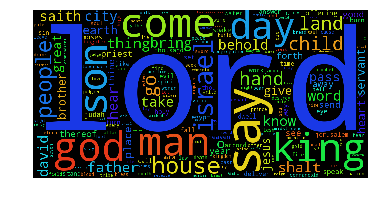

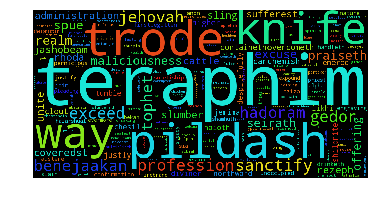

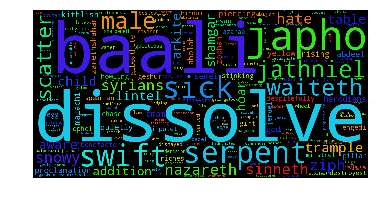

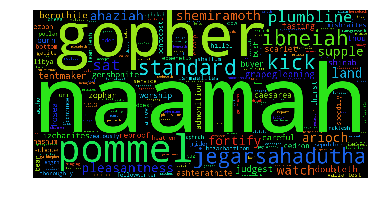

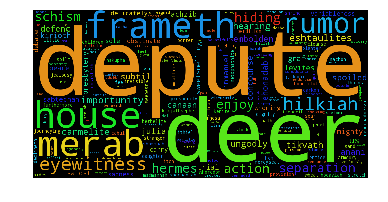

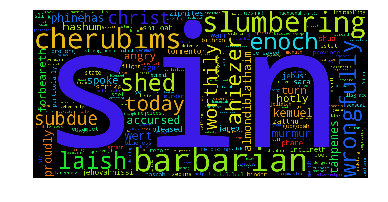

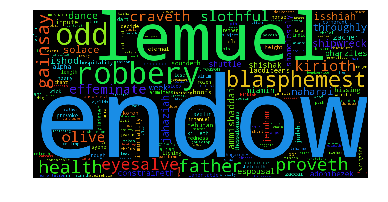

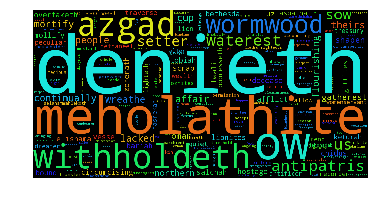

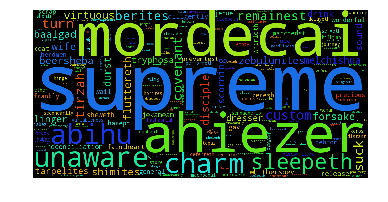

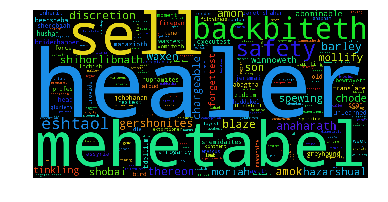

In [29]:
#save the wordclouds generated for presentation
if 0 == 1:
    for t in list(top.keys()):
        plt.figure()
        plt.imshow(WordCloud(width=1000, height=500).fit_words(hdpmodel.show_topic(t, num_words=200)))
        plt.axis("off")
        plt.savefig("topic" + str(t) + ".png", dpi=200, bbox_inches='tight', pad_inches=0.001, transparent=True)